# Twitter Sentiment Analysis - 04 Modeling

The stock market is a focus for investors to maximize their potential profits and consequently, the interest shown from the technical and financial sides in stock market prediction is always on the rise. However, stock market prediction is a problem known for its challenging nature due to its dependency on diverse factors that affect the market, these factors are unpredictable and cannot be taken into consideration such as political variables, and social media effects such as twitter on the stock market.

In this final part of this project, we will combine the stock data and its features, with vectorized representation of the tweets for the month of December 2022 to predict whether or not the adjusted closing price at the end of a trading-day is greater than or less than the previous trading-day. Models run are Logistic Regression, SVM, Random Forest, and Naive Bayes.

Two types of predictions: 
1. Using overall daily tweet sentiment scores to predict adjusted closing price
2. Using vectorized representation of tweets to predict adjusted closing price

**Link(s) to previous notebook(s)**: \
00_Historical_Data_2014: https://github.com/parisvu07/Springboard_Data_Science/tree/main/Capstone_2_Twitter_Sentiment_Analysis \
01_Data_Wrangling:
https://github.com/parisvu07/Springboard/blob/main/Capstone_2_Twitter_Sentiment_Analysis/01_Data_Wrangling.ipynb \
02_Exploratory_Data_Analysis: https://github.com/parisvu07/Springboard/blob/main/Capstone_2_Twitter_Sentiment_Analysis/02_Exploratory_Data_Analysis.ipynb \
03_Preprocessing_and_Training_Data: https://github.com/parisvu07/Springboard/blob/main/Capstone_2_Twitter_Sentiment_Analysis/03_Preprocessing_and_Training_Data.ipynb

Quick fix for "Unable to render rich display": copy and paste the notebook link to https://nbviewer.org

## 4.1 Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
LabeledSentence = gensim.models.doc2vec.TaggedDocument
from tqdm import tqdm
import string
import spacy
np.random.seed(42)

from gensim.models import KeyedVectors 
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
#Importing stock data from notebook "02_Exploratory_Data_Analysis"
stock_data = pd.read_csv('03_stock_data.csv', encoding='latin-1')
stock_data = stock_data.set_index('Dates')
stock_data.head()

,Adj Close,stock_volume,%_change_Open,%_change_High,%_change_Low,%_change_Close,%_change_Volume,twitter_volume
Dates,,,,,,,,
2022-12-01,148.309998,71250400,NaN,NaN,NaN,NaN,NaN,1451
2022-12-02,147.809998,65447400,-1.518116,-0.757731,-0.654803,-0.337132,-8.144516,1551
2022-12-05,146.630005,68826400,1.240064,1.972972,0.082396,-0.798317,5.162925,1738
2022-12-06,142.910004,64727200,-0.473707,-2.398619,-2.641151,-2.536999,-5.955854,2072
2022-12-07,140.940002,69721100,-3.318151,-2.668030,-1.352874,-1.378491,7.715304,1912


In [3]:
#Importing tweet data from previous notebook "03_Preprocessing_and_Training_Data"
tweets_data = pd.read_csv('03_tweets_data.csv')
tweets_data = tweets_data.dropna()

In [4]:
#Importing merged dataframes from previous notebook "03_Preprocessing_and_Training_Data"
merged_dataframes = pd.read_csv('03_merged_dataframes.csv', lineterminator='\n')
merged_dataframes = merged_dataframes.set_index('Dates')
merged_dataframes.head()

,Adj Close,stock_volume,twitter_volume,likes,Subjectivity,Polarity,Sentiment,open_trend,high_trend,low_trend,close_trend,volume_trend,Sentiment_Score
Dates,,,,,,,,,,,,,
2022-12-01,148.309998,71250400,1451,3.358270,0.341031,0.166630,0.418668,0,0,0,0,0,Positive
2022-12-02,147.809998,65447400,1551,2.422508,0.336724,0.179263,0.434727,0,0,0,0,0,Positive
2022-12-05,146.630005,68826400,1738,16.589788,0.285005,0.119601,0.320138,1,1,1,0,1,Negative
2022-12-06,142.910004,64727200,2072,3.363636,0.308533,0.138852,0.345839,0,0,0,0,0,Negative
2022-12-07,140.940002,69721100,1912,3.910183,0.306545,0.141816,0.385379,0,0,0,0,1,Negative


## 4.2 Method 1: Using overall daily tweet sentiment score to predict adjusted closing price

This is a classification problem, in unsupervised learning. Here we have used the following classification models:

Logistic Regression \
K-Nearest Neighbor (KNN) \
Support vector machine (SVM) \
Random Forest \
K-means Clustering 

Evaluating the performance of a model by training and testing on the same dataset can lead to the overfitting. Hence the model evaluation is based on splitting the dataset into train and validation set. But the performance of the prediction result depends upon the random choice of the pair of (train,validation) set. Inorder to overcome that, the Cross-Validation procedure is used where under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.

Classification/ Confusion Matrix: This matrix summarizes the correct and incorrect classifications that a classifier produced for a certain dataset. Rows and columns of the classification matrix correspond to the true and predicted classes respectively. The two diagonal cells (upper left, lower right) give the number of correct classifications, where the predicted class coincides with the actual class of the observation. The off diagonal cells gives the count of the misclassification. The classification matrix gives estimates of the true classification and misclassification rates.


In [5]:
#Transforming "Sentiment_Score" in the merged_dataframes dataset into binary codes
merged_dataframes = pd.get_dummies(merged_dataframes, columns = ['Sentiment_Score'])
merged_dataframes = merged_dataframes.drop(['Polarity'], axis=1)
merged_dataframes.head()

,Adj Close,stock_volume,twitter_volume,likes,Subjectivity,Sentiment,open_trend,high_trend,low_trend,close_trend,volume_trend,Sentiment_Score_Negative,Sentiment_Score_Positive
Dates,,,,,,,,,,,,,
2022-12-01,148.309998,71250400,1451,3.358270,0.341031,0.418668,0,0,0,0,0,0,1
2022-12-02,147.809998,65447400,1551,2.422508,0.336724,0.434727,0,0,0,0,0,0,1
2022-12-05,146.630005,68826400,1738,16.589788,0.285005,0.320138,1,1,1,0,1,1,0
2022-12-06,142.910004,64727200,2072,3.363636,0.308533,0.345839,0,0,0,0,0,1,0
2022-12-07,140.940002,69721100,1912,3.910183,0.306545,0.385379,0,0,0,0,1,1,0


### 4.2.1 Train Test Split

1 means adj. closing price rose compare to its yesterday closing price. 0 means it fell.

In [6]:
#Defining our X and y 
X = merged_dataframes.drop('close_trend', axis=1)
y = merged_dataframes['close_trend'].values.reshape(-1,1)
y[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [7]:
#Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 4.2.2 Logistic Regression

In [8]:
#Making pipeline
C_param_range = [0.001,0.01,0.1,1,10,100]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    pipe = make_pipeline( 
    StandardScaler(),
    LogisticRegression(penalty = 'l2', C = i,random_state = 40)
)

    pipe.fit(X_train, y_train)
    
    # Predict using model
    y_pred_lr = pipe.predict(X_test)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table   

,C_parameter,Accuracy
0,0.001,0.8
1,0.010,0.8
2,0.100,1.0
3,1.000,0.8
4,10.000,0.8
5,100.000,0.8


In [9]:
cnf_matrix = confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
accuracy_lr = pipe.score(X_test,y_test)

print(accuracy_lr)

[[3 1]
 [0 1]]
0.8


In [10]:
cv_scores_test= cross_val_score(pipe,X_test,y_test,cv=2,scoring='roc_auc')
cv_scores_train= cross_val_score(pipe,X_train,y_train,cv=2,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[nan nan]
Mean cross validation test score: nan
Mean cross validation train score: 0.8916666666666667
Standard deviation in cv test scores: nan


We can see that the merged_dataframes (tweets combined with stock sentiments) do not yield meaningful results. We could have create more binary codes for other features such as stock_volume, twitter_volukesm. But because our focus is on Natural Language Processing, we will stop here and move on to a text classfication model using Word2Vec.

## 4.3 Method 2: Using vectorized representation of tweets to predict adjusted closing price

Word2Vec is a collection of algorithms which can produce word embeddings. Word embeddings are vectors which describe the semantic meaning of words as points in space.



In [11]:
#loading pre-trained embedding
wv = KeyedVectors.load('glove-twitter-200.kv')

In [12]:
#Because we got rid of the array before saving in notebook 03, we need to vectorize the text again
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr +=1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

tweets_data['vec'] = tweets_data['tweet_lemmatized'].apply(sent_vec)
tweets_data = tweets_data[['Dates', 'Sentiment', 'clean_text', 'tweet_lemmatized', 'vec']]

tweets_data.head()

,Dates,Sentiment,clean_text,tweet_lemmatized,vec
0,2022-12-30,1.0,new yearâ food tradition around the world,"['new', 'yearâ\x80\x99', 'food', 'tradition', ...","[0.018792242098632932, -0.049044443161359856, ..."
1,2022-12-30,1.0,entrie amp exit daily \ndi cord link belo...,"['entrie', 'amp', 'exit', 'daily', 'di', 'cord...","[0.021105272420890518, -0.0418300421547089, -0..."
2,2022-12-30,0.0,aapl m ft py t la amzn brk b\n\n,"['aapl', 'ft', 'py', 'la', 'amzn', 'brk', 'b']","[-0.06759836408309639, -0.04402014476860442, -..."
3,2022-12-30,1.0,the bigge t â and maybe the be t â financi...,"['bigge', 'â\x80\x94', 'maybe', 'â\x80\x94', '...","[0.044564239627447065, -0.03471527336776711, -..."
4,2022-12-30,1.0,chatroom interm of \n\nalert call analy i ...,"['chatroom', 'interm', 'alert', 'call', 'analy']","[0.02505414104089141, -0.14497853252622817, -0..."


word2vec can’t create a vector from a word that’s not in its vocabulary. Because of this, we need to specify “if word in model.vocab” when creating the full list of word vectors.

In [13]:
# Grab all the tweets
tweets = tweets_data['clean_text']
print(tweets.shape)

(117841,)


In [14]:
#Create a list of strings, where each string is a tweet
tweets_list = [tweet for tweet in tweets]

#Collapse the list of strings into a single long string for processing
big_tweet_string = ' '.join(tweets_list)

#Tokenize the string into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(big_tweet_string)

#Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

#Filter out stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

#Print first 10 words
words[:10]

['new',
 'food',
 'tradition',
 'around',
 'world',
 'entrie',
 'amp',
 'exit',
 'daily',
 'di']

In [15]:
#Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [wv[word] for word in words if word in wv.key_to_index]

#Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in wv.key_to_index]

#Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

#Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
new,0.275540,0.155050,-0.39506,0.350000,0.018967,-0.43623,0.65921,-0.176150,-0.282610,-0.508480,...,0.067459,-0.177820,0.049174,0.26724,-0.061817,0.34782,-0.583470,-0.300400,0.286120,-0.063445
food,-0.691750,-0.142590,0.38653,-0.231410,-0.204080,-0.21565,0.77839,0.002269,-0.072446,-0.601340,...,-0.250490,-0.336230,0.184910,-0.48235,0.314250,0.24499,-0.244040,0.080309,0.340600,0.704510
tradition,-0.468270,-0.077617,0.37846,0.035308,-0.092955,-0.27471,0.39512,-0.166380,0.125070,0.041850,...,0.383770,-0.020489,0.803810,-0.17868,0.054530,0.21030,0.703030,-0.295210,0.294710,-0.601420
around,-0.540240,-0.173280,0.49958,-0.219800,0.187340,0.45666,0.86513,-0.286110,-0.450310,0.468560,...,0.215700,0.204540,-0.503040,-0.14797,0.257760,0.26054,0.322950,0.189860,0.022764,0.073641
world,0.035771,0.629460,0.27443,-0.364550,0.391890,-0.41298,0.12398,-0.349950,0.277250,0.000376,...,0.433180,-0.230370,0.019838,-0.21725,0.168180,0.61857,0.009801,0.113410,0.029805,-0.619340


### 4.3.1 Dimensionality Reduction with t-SNE

In [16]:
#Initialize t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

#Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

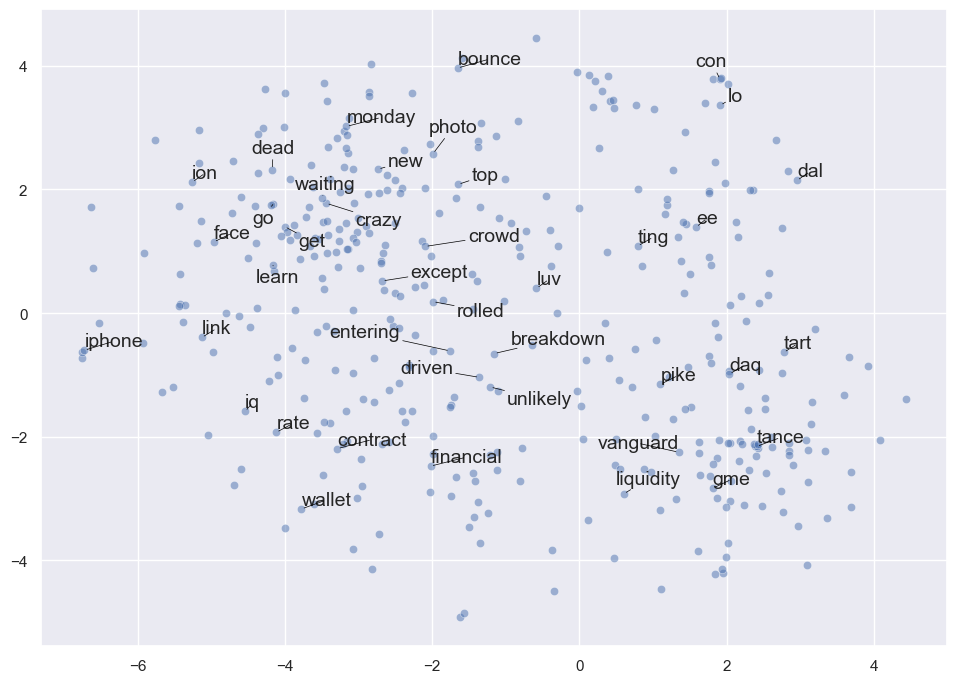

In [17]:
sns.set()
#Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

#Import adjustText, initialize list of texts
from adjustText import adjust_text

texts = []
words_to_plot = list(np.arange(0, 400, 10))

#Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
#Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

We see certain items clustering together. For example, we have movement terms in the upper left, we have corporate finance terms near the bottom.

### 4.3.2 Logistic Regression

In [18]:
X = tweets_data['vec'].to_list()
y = tweets_data['Sentiment'].to_list()

In [19]:
#Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# Apply logistic regression model to training data
Logreg = LogisticRegression()
Logreg.fit(X_train, y_train)
    
# Predict using model
y_pred_lr = Logreg.predict(X_test)

In [21]:
cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
Accuracy_lr = Logreg.score(X_test,y_test)

print(Accuracy_lr)

[[   8  808 1564]
 [  32 9931 2845]
 [  16 2533 5832]]
0.6691416691416692


Accuracy tells you how many times the ML model was correct overall. Precision is how good the model is at predicting a specific category. Recall tells you how many times the model was able to detect a specific category.

Micro-averaged: all samples equally contribute to the final averaged metric

In [22]:
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Precision:", metrics.precision_score(y_test, y_pred_lr, average='micro'))
print("Logistic Regression Recall:", metrics.recall_score(y_test, y_pred_lr, average='micro'))

Logistic Regression Accuracy: 0.6691416691416692
Logistic Regression Precision: 0.6691416691416692
Logistic Regression Recall: 0.6691416691416692


### 4.3.3 Support Vector Machine (SVM)

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict using model:

y_predict_svm=svm.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_svm)
print(cnf_matrix)

Accuracy_svm=svm.score(X_test,y_test)
print(Accuracy_svm)

[[   0  692 1688]
 [   0 9705 3103]
 [   0 2203 6178]]
0.6738936738936739


In [24]:
cv_scores_test= cross_validate(svm,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_validate(svm,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_svm_test= np.mean(cv_scores_test)
cv_scores_svm_train= np.mean(cv_scores_train)
cv_scores_std_svm= np.std(cv_scores_test)
print ('Mean cross validation test score: ' +str(cv_scores_svm_test))
print ('Mean cross validation train score: ' +str(cv_scores_svm_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_svm))

{'fit_time': array([62.9754653 , 62.56079006, 62.07354808, 63.453578  , 63.56051922]), 'score_time': array([0.02747393, 0.00255013, 0.00245404, 0.00244403, 0.00192189]), 'test_score': array([nan, nan, nan, nan, nan])}


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

### 4.3.4 Random Forest (RF)

In [26]:
from sklearn.ensemble import RandomForestClassifier

#Apply RF to the training data:

rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')
rf.fit(X_train, y_train)

#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[  528   805  1047]
 [    7 11647  1154]
 [   13  1684  6684]]
0.8001612287326573


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

### 4.3.6 Gradient Boosting

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train, y_train)

#Predict using the model:

y_predict_gbc = gbc.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gbc)
print(cnf_matrix)
Accuracy_gbc=gbc.score(X_test,y_test)
print(Accuracy_gbc)

In [ ]:
from sklearn.cross_validation import cross_val_score

cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

### 4.3.7 Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)

#Predict using the model:

y_predict_nb=nb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_nb)
print(cnf_matrix)
Accuracy_nb=nb.score(X_test,y_test)
print(Accuracy_nb)

In [ ]:
from sklearn.cross_validation import cross_val_score

cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

## 4.4 Models Comparison

In [ ]:
myLabels = [ 'Logistic Regression','KNN','SVM','Random Forest','Gradient Boost', 'Naive Bayes']
score_test= [  cv_scores_lr_test,cv_scores_knn_test,cv_scores_svm_test,cv_scores_rf_test,cv_scores_nb_test]
score_train= [  cv_scores_lr_train,cv_scores_knn_train,cv_scores_svm_train,cv_scores_rf_train,cv_scores_nb_train]
Accuracy_score = [Accuracy_lr,Accuracy_knn,Accuracy_svm,Accuracy_rf,Accuracy_gbc,Accuracy_nb]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

In [ ]:
#plotting the accuracy scores:

index=[1,2,3,4,5,6]
index_acc=[1.2,2.2,3.2,4.2,5.2,6.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3,4,5,6], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()

#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4,5,6]
index_acc=[1.2,2.2,3.2,4.2,5.2,6.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2,3,4,5,6], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

## 4.5 Grid Search CV & Hyperparameter Tuning

### 4.5.1 Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

### Fitting the Random forest model with the optimal hyperparameters

In [ ]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
y_predictions_rf = rf.predict(X_test)
acc = accuracy_score(y_test, y_predictions)
cv = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
print(acc)
print(cv)

In [ ]:
#Final prediction RF:

target = pd.Series(y_predictions_rf, name='Car_cancellations')
user_id = df_new['user_id']

output = pd.DataFrame(list(zip(user_id, target)), 
               columns =['User_ID', 'Car cancellations']) 




output.to_csv('final_result_rf.csv', index=False, header=True)

In [ ]:
#Feature importances:

features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#Visual comparison:
plt.figure(figsize=(10,5))
#indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.savefig("28.png")
plt.show()
#len(importances)

### ROC-AUC Score and the ROC curve:

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

### 4.5.2 Gradient Boost

In [ ]:
GB = GradientBoostingClassifier()
gb_param = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
        }

gsGB = GridSearchCV(GB, param_grid = gb_param, cv=3, scoring="accuracy", n_jobs= -1, verbose = 1)
gsGB.fit(X_train,y_train)
print(gsGB.best_estimator_)
print(gsGB.best_score_)

### Fitting the Gradient Boost model with the optimal hyperparameters

In [ ]:
GB= GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
GB.fit(X_train, y_train)
y_predictions_GB = GB.predict(X_test)
acc_GB = accuracy_score(y_test, y_predictions_GB)
cv_GB = cross_val_score(GB, X_test, y_test,scoring='roc_auc').mean()
print(acc_GB)
print(cv_GB)

In [ ]:
#Final prediction GB:

target = pd.Series(y_predictions_GB, name='Car_cancellations')
user_id = df_new['user_id']

output = pd.DataFrame(list(zip(user_id, target)), 
               columns =['User_ID', 'Car cancellations']) 




output.to_csv('final_result_gb.csv', index=False, header=True)

In [ ]:
features = X
importances = list(GB.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#visually:
plt.figure(figsize=(10,5))
#indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
_=plt.barh(index,imp, align='center',color='gold',edgecolor='k')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Gradient boost Classifier model',fontsize=15)
plt.savefig("29.png")
plt.show()
#len(importances)

### ROC-AUC Score and the ROC curve:

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
y_scores_gb = GB.predict_proba(X_test)
y_scores_gb = y_scores_gb[:,1]
auroc = roc_auc_score(y_test, y_scores_gb)
print("ROC-AUC Score:", auroc)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_gb)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (GB)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("31.png")
plt.show()

## 4.6 Conclusions

In order to predict the sentiment of each tweet, we have vectorized the tweets and applied classification machine learning models.

This is a classification problem. Here we have used the following classification models:

Logistic Regression
K-Nearest Neighbor (KNN)
Support vector machine (SVM)
Random Forest
Naive Bayes
Gradient Boost
Evaluating the performance of a model by training and testing on the same dataset can lead to the overfitting. Hence the model evaluation is based on splitting the dataset into train and validation set. But the performance of the prediction result depends upon the random choice of the pair of (train,validation) set. Inorder to overcome that, the Cross-Validation procedure is used where under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.

We have evaluated each models in terms of model accuracy score, and 'ROC-AUC' score for both the training and test data, and plotted them. The two best performing models are the Random forest and the Gradient boost. Both are the ensemble model, based on decision trees.

Next, we have carried out the grid search CV for the hyperparameter tuning for both the models seperately. This step was the most time consuming one in terms of computation. (The RF model took much longer time). With the result of the optimized hyperparameters, we have again fitted the two models, and got the predictions seperately.

We have evaluated the ROC-AUC scores with the optimized hyperparameters. Clearly, the model performance improved with the optimized parameters. The final ROC-AUC scores fro both RF and the GB are 0.886 and 0.899

The final prediction tables (Two columns: User ID and Car_cancellations) are saved as csv files.

## 4.7 Possible Directions for the Future

There are possible alternative features to determine the sentiments of each tweet such as the change in stock price itself. Also, here we have used only the tweet data for the month of December 2022. The model can be improved, if we can use the data of the whole year of 2022.

We can also use ensembles of the machine learning models to average out bias and improve performance.

Try to use more feature engineering. In this project, we have negnected the change in prices of the stock in the final models.